In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import string
import torchtext
from torchtext.data.utils import get_tokenizer

# 1. Read Data
file_path = '/content/drive/MyDrive/movie.csv'  # Replace with your file path
movie_data = pd.read_csv(file_path)

# 2. Remove punctuation and digits from comments
def remove_punctuation_and_digits(text):
    return text.translate(str.maketrans('', '', string.punctuation + string.digits))

movie_data['cleaned_comment'] = movie_data['comment'].apply(remove_punctuation_and_digits)

# 3. Tokenize using torchtext
tokenizer = get_tokenizer("basic_english")
movie_data['tokenized_comment'] = movie_data['cleaned_comment'].apply(tokenizer)

# View processed data
print(movie_data[['comment', 'cleaned_comment', 'tokenized_comment']].head())

                                             comment  \
0  Listening in to a conversation between his doc...   
1  A brother and sister with a past incestuous re...   
2  As the bus empties the students for their fiel...   
3  To help their unemployed father make ends meet...   
4  The film's title refers not only to the un-rec...   

                                     cleaned_comment  \
0  Listening in to a conversation between his doc...   
1  A brother and sister with a past incestuous re...   
2  As the bus empties the students for their fiel...   
3  To help their unemployed father make ends meet...   
4  The films title refers not only to the unrecov...   

                                   tokenized_comment  
0  [listening, in, to, a, conversation, between, ...  
1  [a, brother, and, sister, with, a, past, inces...  
2  [as, the, bus, empties, the, students, for, th...  
3  [to, help, their, unemployed, father, make, en...  
4  [the, films, title, refers, not, only, to, the..

In [ ]:
import gensim
model = gensim.models.Word2Vec(movie_data['tokenized_comment'], vector_size=300, window=5, min_count=10, workers=4)
model.train(movie_data['tokenized_comment'], total_examples=model.corpus_count, epochs=model.epochs)
# 3. Use the model to get word vectors
vector = model.wv['movie']
# View word vector
print(vector)

[ 1.5612069  -0.33088684 -0.12444365  1.1169889  -0.49167553  1.6409
 -0.62694263 -0.42296076  0.07017151  0.30688584 -0.81503195 -2.4150217
  0.60396415  0.1953968  -1.1387953   0.10860922  1.692322   -0.35708728
  0.79222494 -0.05084139  0.0622489   0.08045752 -0.53655005  0.09032746
 -1.2653705  -0.8644589  -0.5436416  -0.562497    0.1767839   0.95632845
 -0.4617368   1.4110317   0.02329496 -1.4738669   0.14209488 -0.00631555
 -0.8053188  -1.0904939   1.0237795   0.27582744 -0.52487385  1.3886155
 -0.1715262   0.599352    0.32274118 -0.88874185  0.9494282  -0.59447503
  0.7149535  -2.7690651  -0.49113575 -0.44289467  0.43913466  1.1848592
 -0.41325584 -0.98636365  0.06541509 -0.35241908 -0.7626108  -1.3459704
 -1.1039256   0.265897    0.0742055  -0.83519065  0.4799615   0.6415965
  0.11248821  1.0396608  -0.6110369   0.10082378  0.50839686  0.046845
 -1.2094338  -0.79635936  1.0889723  -1.1922337   0.01908717 -0.39249697
 -0.60991096  0.37272188 -0.12460682  0.3521387  -0.36591473  

In [ ]:
import numpy as np

# Initialize feature vector list
feature_vectors = []

# Generate a feature vector for each comment
for tokens in movie_data['tokenized_comment']:
    vector_sum = np.zeros(model.vector_size)
    words_in_model = 0

    for token in tokens:
        if token in model.wv:
            vector_sum += model.wv[token]
            words_in_model += 1

    # Avoid division by zero
    if words_in_model > 0:
        average_vector = vector_sum / words_in_model
    else:
        average_vector = vector_sum

    feature_vectors.append(average_vector)

# Convert feature vector list to Numpy array for subsequent processing
feature_vectors = np.array(feature_vectors)

# Feature vector dimension should be consistent with Word2Vec model's vector_size
print("Dimension of feature vectors:", feature_vectors.shape)

Dimension of feature vectors: (54214, 300)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of the label encoder
label_encoder = LabelEncoder()

# Fit and transform labels
encoded_labels = label_encoder.fit_transform(movie_data['type'])

# Display a few encoded labels
print("Example of encoded labels:", encoded_labels[:5])

# Display corresponding original labels
print("Example of original labels:", movie_data['type'][:5].values)


Example of encoded labels: [ 8 24  1  8  8]
Example of original labels: ['drama' 'thriller' 'adult' 'drama' 'drama']


In [ ]:
from sklearn.model_selection import train_test_split

# Feature vectors and labels
X = feature_vectors  # Previously calculated feature vectors
y = encoded_labels   # Previously encoded labels

# Initial split: 80% training set and 20% remaining data set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the size of each data set to confirm the split
print("Training set size:", len(X_train))
print("Validation set size:", len(X_valid))

Training set size: 43371
Validation set size: 10843


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class TextLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional, dropout_prob):
        super(TextLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)

        # Fully connected layer
        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        # Initialize hidden and cell states for LSTM
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Dropout layer
        out = self.dropout(out[:, -1, :])

        # Fully connected layer
        out = self.fc(out)

        return out

# Network parameters
input_size = 300 # Set according to Word2Vec word vector dimension
hidden_size = 500
output_size = len(set(encoded_labels)) # Number of categories
num_layers = 2
bidirectional=True
dropout_prob = 0.1

# Create model instance
model = TextLSTM(input_size, hidden_size, output_size, num_layers, bidirectional, dropout_prob)

print(model)

TextLSTM(
  (lstm): LSTM(300, 500, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1000, out_features=27, bias=True)
)


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Convert feature vectors and labels to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Create Dataset objects
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
valid_dataset = TextDataset(X_valid_tensor, y_valid_tensor)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import torch.optim as optim
import torch.nn as nn
import torch

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, all_labels, all_predictions = 0, 0, [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / len(train_loader.dataset)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    return avg_loss, avg_accuracy, precision, recall, f1

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss, total_correct, all_labels, all_predictions = 0, 0, [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / len(val_loader.dataset)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    return avg_loss, avg_accuracy, precision, recall, f1

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_accuracy = 0

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, accuracy: {train_accuracy:.4f}, precision: {train_precision:.4f}, recall: {train_recall:.4f}, F1: {train_f1:.4f}, Val loss: {val_loss:.4f}, accuracy: {val_accuracy:.4f}, precision: {val_precision:.4f}, recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10 - Train loss: 1.7451, accuracy: 0.4963, precision: 0.4273, recall: 0.4963, F1: 0.4309, Val loss: 1.5067, accuracy: 0.5431, precision: 0.4975, recall: 0.5431, F1: 0.4869


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/10 - Train loss: 1.4660, accuracy: 0.5526, precision: 0.5040, recall: 0.5526, F1: 0.5099, Val loss: 1.4287, accuracy: 0.5590, precision: 0.5153, recall: 0.5590, F1: 0.5192


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/10 - Train loss: 1.4010, accuracy: 0.5657, precision: 0.5255, recall: 0.5657, F1: 0.5280, Val loss: 1.4024, accuracy: 0.5626, precision: 0.5266, recall: 0.5626, F1: 0.5201


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/10 - Train loss: 1.3643, accuracy: 0.5722, precision: 0.5364, recall: 0.5722, F1: 0.5379, Val loss: 1.3856, accuracy: 0.5699, precision: 0.5299, recall: 0.5699, F1: 0.5374


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/10 - Train loss: 1.3262, accuracy: 0.5821, precision: 0.5480, recall: 0.5821, F1: 0.5500, Val loss: 1.3827, accuracy: 0.5687, precision: 0.5399, recall: 0.5687, F1: 0.5339


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/10 - Train loss: 1.2962, accuracy: 0.5871, precision: 0.5551, recall: 0.5871, F1: 0.5570, Val loss: 1.3667, accuracy: 0.5736, precision: 0.5427, recall: 0.5736, F1: 0.5394


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/10 - Train loss: 1.2592, accuracy: 0.5959, precision: 0.5712, recall: 0.5959, F1: 0.5683, Val loss: 1.3681, accuracy: 0.5740, precision: 0.5431, recall: 0.5740, F1: 0.5391


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/10 - Train loss: 1.2209, accuracy: 0.6053, precision: 0.5812, recall: 0.6053, F1: 0.5801, Val loss: 1.3728, accuracy: 0.5787, precision: 0.5495, recall: 0.5787, F1: 0.5514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/10 - Train loss: 1.1750, accuracy: 0.6177, precision: 0.5967, recall: 0.6177, F1: 0.5944, Val loss: 1.3897, accuracy: 0.5746, precision: 0.5475, recall: 0.5746, F1: 0.5492
Epoch 10/10 - Train loss: 1.1195, accuracy: 0.6320, precision: 0.6155, recall: 0.6320, F1: 0.6116, Val loss: 1.4009, accuracy: 0.5723, precision: 0.5515, recall: 0.5723, F1: 0.5513


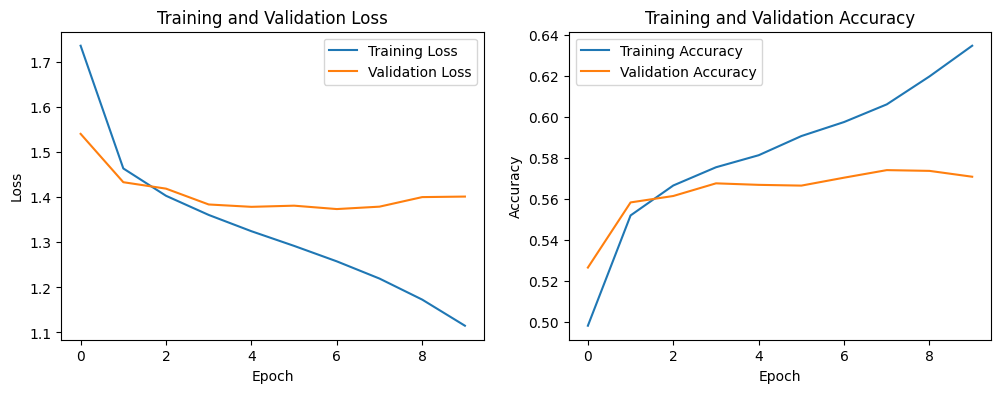

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# 创建SVM分类器实例
svm_classifier = SVC(kernel='linear')  # 你可以选择不同的核，例如 'linear', 'poly', 'rbf', 'sigmoid'

# 训练模型
svm_classifier.fit(X_train, y_train)

# 在验证集上进行预测
y_pred = svm_classifier.predict(X_valid)

# 评估模型
accuracy = accuracy_score(y_valid, y_pred)
report = classification_report(y_valid, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


KeyboardInterrupt: ignored